<a href="https://colab.research.google.com/github/DhruvaBansal00/ConfidentMT/blob/master/driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls
%cd drive/My Drive/ConfidentMachineTranslation/flores
!ls
!pwd
import sys
sys.path.append('/content/drive/My Drive/ConfidentMachineTranslation/flores/src/')

drive  sample_data
/content/drive/My Drive/ConfidentMachineTranslation/flores
analysis			      FeatureSubsetBinaryClassifers.ipynb
Analysis			      FLORES.ipynb
backward_models			      LanguageAnalysis.ipynb
BoostedBinaryClassifers.ipynb	      language_models
checkpoints			      LM_Thresholding.ipynb
ClassificationDataset		      NCD_Analysis.ipynb
CompareBaselineWithClassifiers.ipynb  NNClassification.ipynb
configs				      noisychannel
data				      NoisyChannel.ipynb
data-bin			      Resources
driver.ipynb			      scripts
Ensembles			      src
Ensembling
/content/drive/My Drive/ConfidentMachineTranslation/flores


In [3]:
pip install fairseq sacrebleu sentencepiece fastBPE sacremoses

     |████████████████████████████████| 307kB 6.3MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 1.1MB 754kB/s 
     |████████████████████████████████| 890kB 1.4MB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2021138 sha256=8ef40b10a3fd55390d660f51c9fce46a828f762f712dcbd8f47919c3067214b9
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp36-cp36m-linux_x86_64.whl size=481506 sha256=fe80d55feaf2b87586e827f7dc910f22b4319e83f3458e45334f7a3073d57d79
  Stored in directory: /root/.cache/pip/wheels/f3/0c/9c/fc62058b4d473a5602bcd3d3edfece796f123875379ea82d79
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=81b20ec7f64fcdf6f4a3595c77a1236ba7f69a6cf60752dace03e062d7069171
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a5012

In [0]:
##Methods for CLI with fairseq - WIP

class FairseqWrapper:

    def runFairseqGenerate(self, dataFolder, sourceLang, targetLang, fwModel, beam, lenpen, dataSet, removeBpe, saveFile):
        !fairseq-generate $dataFolder --source-lang $sourceLang --target-lang $targetLang \
        --path $fwModel --beam $beam --lenpen $lenpen --gen-subset $dataSet --remove-bpe=$removeBpe --sacrebleu > $saveFile

    def runFairseqScore(self, translations, groundTruth, saveFile):
        !fairseq-score --sys $translations --ref $groundTruth --sentence-bleu > $saveFile
    
    def runFairseqPreprocess(self, srcdict, preprocCommand, bpeTranslations, dest):
        !fairseq-preprocess --only-source --srcdict $srcdict --$preprocCommand $bpeTranslations \
        --destdir $dest --workers 20

    def runFairseqEvalLM(self, preprocFile, lmModel, batchSize, maxTokens, dataSet, saveFile):
        !fairseq-eval-lm $preprocFile --path $lmModel --batch-size $batchSize --max-tokens $maxTokens \
        --output-word-probs --sample-break-mode eos --gen-subset $dataSet > $saveFile

In [0]:
dataFolder = "data-bin/wiki_ne_en_bpe5000/"
fwModel = "Ensembles/April_04.pt"
bwModel = "backward_models/April_17.pt"
lmModel = "language_models/lm/checkpoint_best.pt"
sourceLang = "ne"
targetLang = "en"
dataSet = "test"


  0% 0/14 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
  0% 0/15 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
Namespace(align_suffix=None, alignfile=None, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='analysis/preprocessed_translations', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=1000, lr_scheduler='fixed', memory_efficient_fp16=False, min_loss_scale=0.0001, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_so

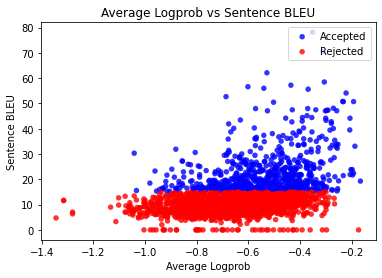

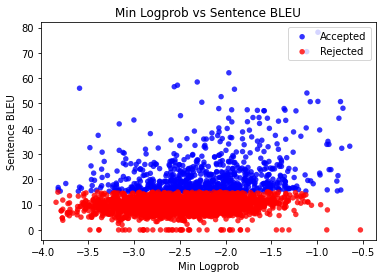

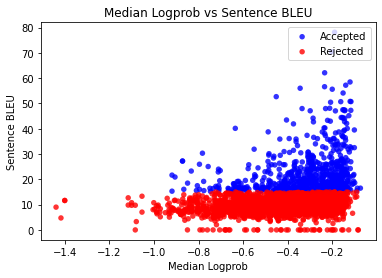

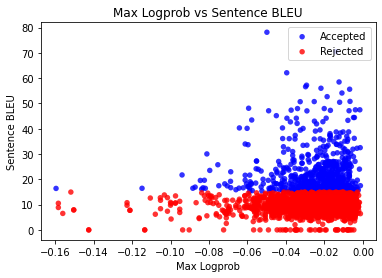

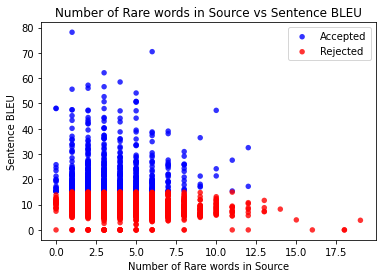

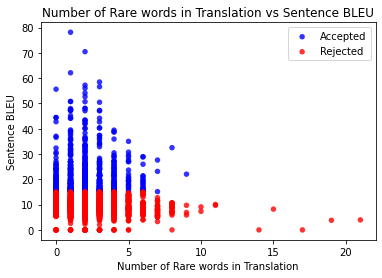

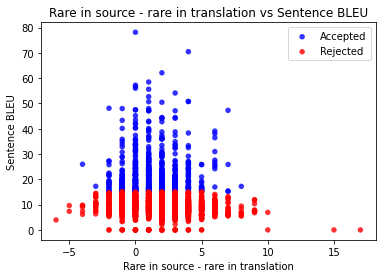

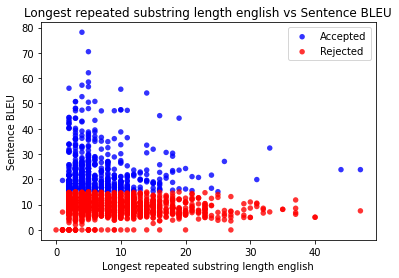

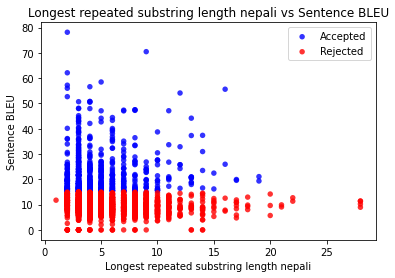

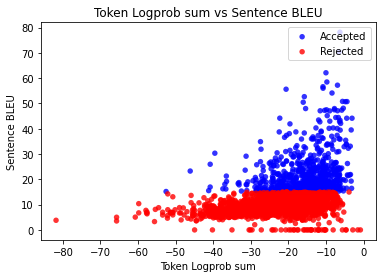

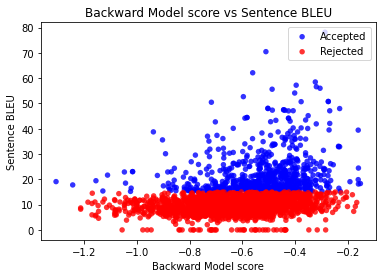

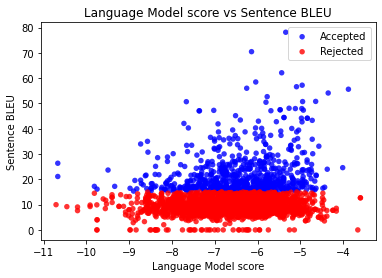

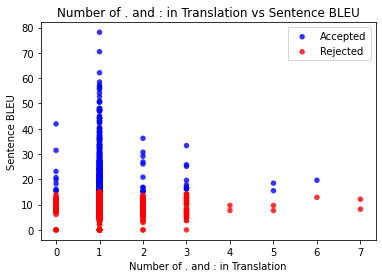

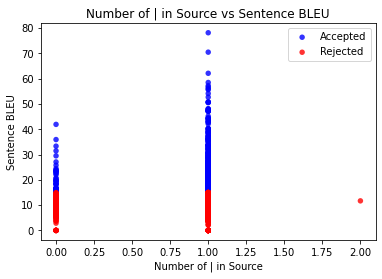

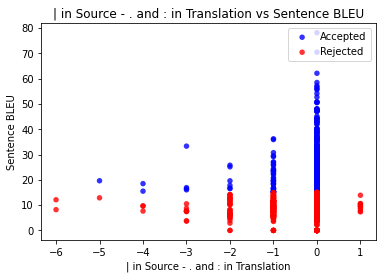

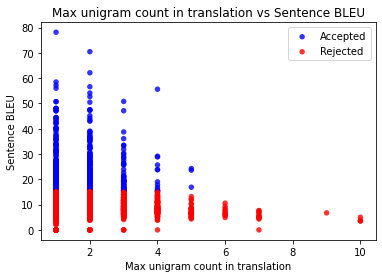

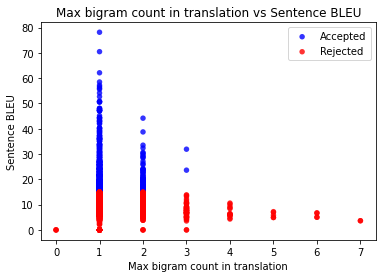

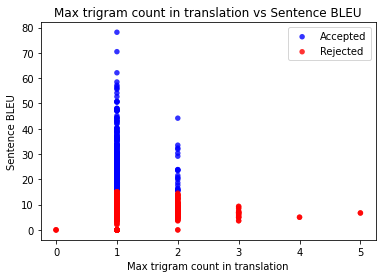

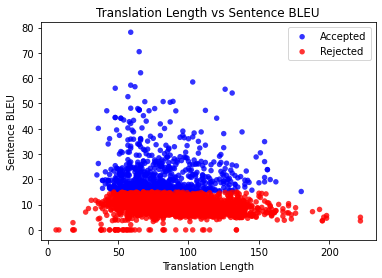

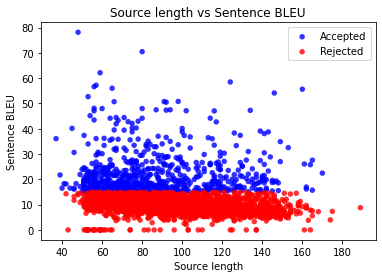

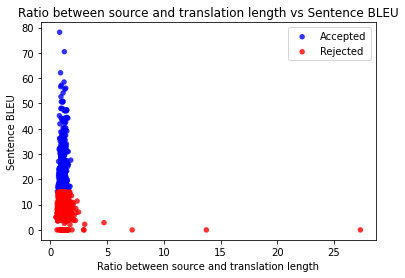

2835


In [5]:

import translationUtils
from translation import Translation

translations = translationUtils.getTranslationFromDataset(dataSet, fwModel, bwModel, lmModel, "ne", "en", FairseqWrapper(), dataFolder, True, True)
print(len(translations))

In [8]:
import dataUtils
translations = dataUtils.createObjectsFromFile(dataSet)

for translation in translations:
    print(translation.sourceLength)

51.0
52.0
67.0
65.0
55.0
56.0
61.0
63.0
54.0
54.0
72.0
51.0
53.0
68.0
54.0
68.0
55.0
51.0
53.0
67.0
70.0
58.0
46.0
56.0
63.0
52.0
72.0
56.0
69.0
52.0
50.0
53.0
67.0
64.0
49.0
62.0
52.0
57.0
52.0
52.0
60.0
64.0
54.0
64.0
54.0
63.0
54.0
57.0
54.0
57.0
56.0
52.0
60.0
61.0
58.0
57.0
45.0
63.0
52.0
54.0
58.0
63.0
52.0
52.0
63.0
59.0
80.0
64.0
59.0
74.0
66.0
59.0
71.0
63.0
78.0
56.0
59.0
68.0
68.0
72.0
54.0
63.0
64.0
56.0
80.0
56.0
59.0
67.0
52.0
52.0
64.0
74.0
42.0
67.0
67.0
68.0
53.0
54.0
75.0
71.0
60.0
62.0
75.0
71.0
51.0
51.0
54.0
59.0
52.0
72.0
61.0
56.0
68.0
54.0
69.0
63.0
63.0
62.0
62.0
66.0
62.0
56.0
63.0
63.0
73.0
53.0
56.0
72.0
63.0
60.0
62.0
56.0
74.0
52.0
54.0
57.0
54.0
53.0
56.0
52.0
52.0
73.0
54.0
62.0
66.0
51.0
74.0
59.0
56.0
51.0
59.0
53.0
46.0
57.0
51.0
51.0
58.0
56.0
49.0
58.0
56.0
57.0
52.0
53.0
56.0
58.0
55.0
46.0
57.0
64.0
58.0
52.0
65.0
48.0
80.0
52.0
60.0
56.0
64.0
56.0
58.0
56.0
53.0
56.0
63.0
64.0
66.0
53.0
48.0
53.0
53.0
63.0
62.0
66.0
62.0
55.0
57.0
53.0
56.0
59.0
